
 * simulations avec différents MCs
 * ring avec représentation de la vitesse angulaire
 
 
<!-- TEASER_END -->


In [1]:

%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import MotionClouds as mc

fig_width_pt = 646.79  # Get this from LaTeX using \showthe\columnwidth
inches_per_pt = 1.0/72.27               # Convert pt to inches
fig_width = fig_width_pt*inches_per_pt  # width in inches

In [2]:
sf_0 = 0.15
B_sf = 0.05
theta_0 = np.pi/2
B_theta = 0.15
loggabor = True

def get_grids(N_X, N_Y):
    fx, fy = np.mgrid[(-N_X//2):((N_X-1)//2 + 1), (-N_Y//2):((N_Y-1)//2 + 1)]
    fx, fy = fx*1./N_X, fy*1./N_Y
    return fx, fy

def frequency_radius(fx, fy):
    N_X, N_Y = fx.shape[0], fy.shape[1]
    R2 = fx**2 + fy**2
    R2[N_X//2 , N_Y//2] = np.inf
    return np.sqrt(R2)

def envelope_orientation(fx, fy, theta_0=theta_0, B_theta=B_theta, norm = True):
    theta = np.arctan2(fx, fy)
    env =  np.exp(np.cos(2*(theta-theta_0))/B_theta**2)
    #return (1/(2*np.pi*iv(0, (1/((B_theta)**2)))))*env
    if norm: env /= np.sqrt((env**2).sum())
    return env

def envelope_radial(fx, fy, sf_0=sf_0, B_sf=B_sf, loggabor=loggabor, norm = True):
    if sf_0 == 0.: return 1.
    if loggabor:
        fr = frequency_radius(fx, fy)
        env = 1./fr*np.exp(-.5*(np.log(fr/sf_0)**2)/(np.log((sf_0+B_sf)/sf_0)**2))
        if norm: env /= np.sqrt((env**2).sum())
        return env
    else:
        return np.exp(-.5*(frequency_radius(fx, fy) - sf_0)**2/B_sf**2)

fx, fy = get_grids(mc.N_X, mc.N_Y)
fr = frequency_radius(fx, fy)

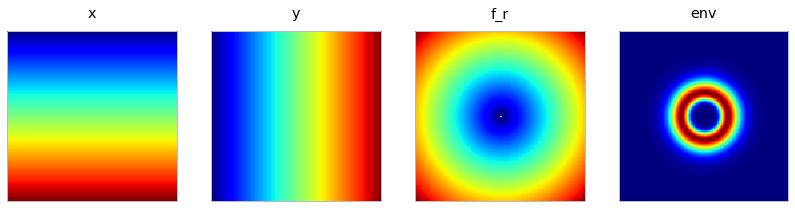

In [27]:
env = envelope_radial(fx, fy)

fig, ax = plt.subplots(1, 4, figsize=(14, 9))
for i, (f, label) in enumerate(zip([fx, fy, fr, env], ['x', 'y', 'f_r', 'env'])):
    ax[i].matshow(f)
    ax[i].set_title(label)
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    

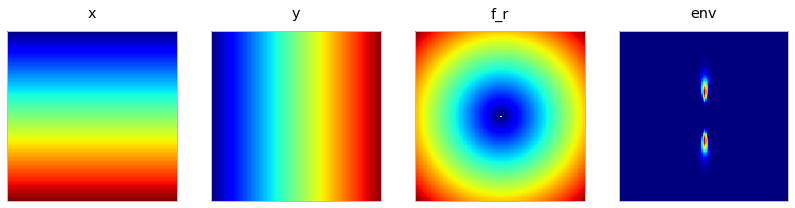

In [28]:
env = envelope_radial(fx, fy) * envelope_orientation(fx, fy)

fig, ax = plt.subplots(1, 4, figsize=(14, 9))
for i, (f, label) in enumerate(zip([fx, fy, fr, env], ['x', 'y', 'f_r', 'env'])):
    ax[i].matshow(f)
    ax[i].set_title(label)
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    

# Figure

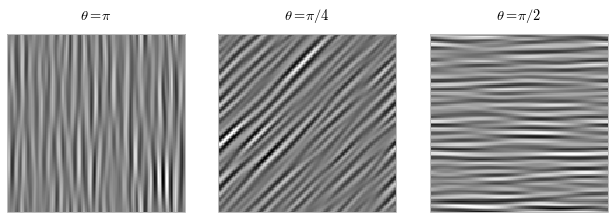

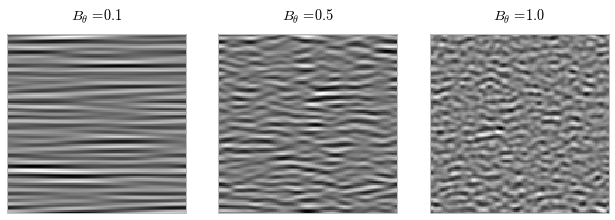

In [5]:
#  réalisation du motion clouds

theta0 = np.pi/2
Btheta = 0.15
theta_0 = [0, np.pi/4, np.pi/2]
B_theta = [0.1, 0.5, 1.]

def texture(env):
 return np.fft.fft2(np.fft.ifftshift(env * np.exp(1j * 2 * np.pi * np.random.rand(mc.N_X, mc.N_Y)))).real

fig, ax = plt.subplots(1, 3, figsize=(fig_width, fig_width*6/18))
for i, (theta0_, label) in enumerate(zip(theta_0, [r'$\theta = \pi$', r'$\theta = \pi/4$', r'$\theta = \pi/2$']) ) :
    env = envelope_radial(fx, fy) * envelope_orientation(fx, fy, theta_0=theta0_, B_theta=Btheta)
    I = texture(env)
    ax[i].matshow(I, cmap=plt.cm.gray)
    ax[i].set_title(label)
#    ax[i].set_xticks(np.linspace(0, 120, 5))
#    ax[i].set_yticks(np.linspace(0, 120, 5))
    ax[i].set_xticks([])
    ax[i].set_yticks([])
#plt.title(u'Réalisation du Motion Clouds')
plt.tight_layout()
fig.savefig('figures/realisation_MC_theta0(week4).pdf')


fig, ax = plt.subplots(1, 3, figsize=(fig_width, fig_width*6/18))
for i, (Btheta_, label) in enumerate(zip(B_theta, [r'$B_\theta = 0.1$', r'$B_\theta = 0.5$', r'$B_\theta = 1.0$']) ) :
    env = envelope_radial(fx, fy) * envelope_orientation(fx, fy, theta_0=theta0, B_theta=Btheta_)
    I = texture(env)
    ax[i].matshow(I, cmap=plt.cm.gray)
    ax[i].set_title(label)
    ax[i].set_xticks([])
    ax[i].set_yticks([])
#plt.title(u'Réalisation du Motion Clouds')
plt.tight_layout()
fig.savefig('figures/realisation_MC_Btheta(week4).pdf')



## Réponse théorique de l'énergie du filtre linéaire

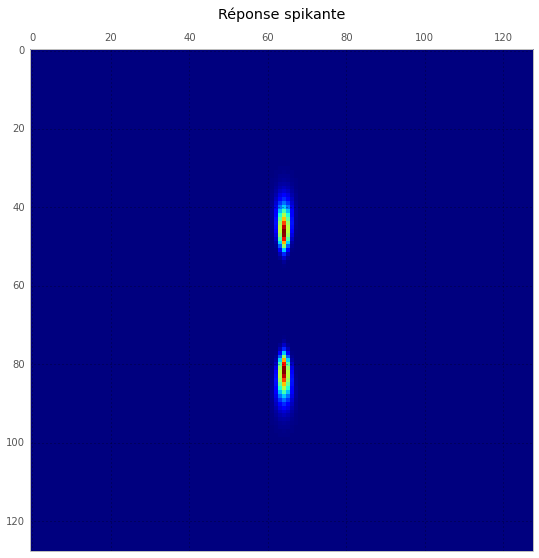

In [6]:
# prédiction de la réponse spikante maximale

env = envelope_radial(fx, fy) * envelope_orientation(fx, fy)

reponse = env**2

fig, ax = plt.subplots(figsize=(14, 9))
ax.matshow(reponse)
plt.title(u'Réponse spikante')

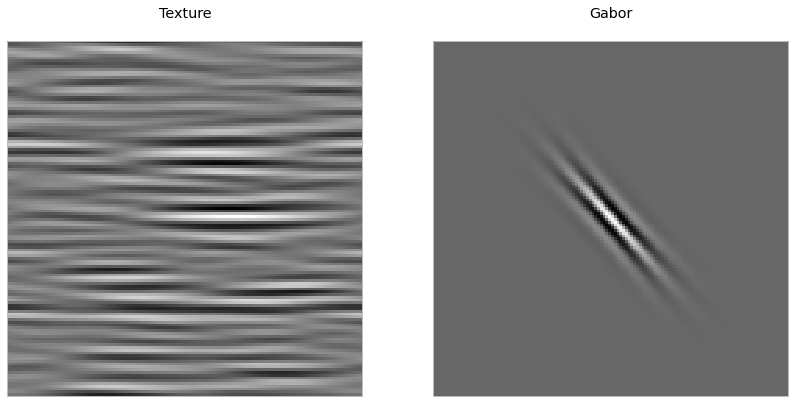

In [7]:
# montrons que la convolution d'un MC avec un gabor donne un von - Mises
sf_0 = 0.15
B_sf = 0.05
theta_0 = np.pi/2
B_theta = 0.15
loggabor = True
# testons d'abord la convolution avec un angle arbitraire
seed = None
np.random.seed(seed=seed)
def texture(env):
    I= np.fft.fftshift(np.fft.ifft2(np.fft.ifftshift(env * np.exp(1j * 2 * np.pi * np.random.rand(mc.N_X, mc.N_Y)))).real)
    #I /= np.sqrt((env**2).sum())
    I /= env.sum()
    return I

def impulse(env, phi=2 * np.pi):
    I = np.fft.fftshift(np.fft.ifft2(np.fft.ifftshift(env * np.exp(1j * phi))).real)
    #I /= np.sqrt((env**2).sum())
    I /= env.sum()
    return I

env_in = envelope_radial(fx, fy, sf_0=sf_0, B_sf=B_sf) * envelope_orientation(fx, fy, theta_0=theta_0, B_theta=B_theta)
env_V1 = envelope_radial(fx, fy, sf_0=sf_0, B_sf=B_sf) * envelope_orientation(fx, fy, theta_0=np.random.rand()*np.pi, B_theta=B_theta)

fig, ax = plt.subplots(1, 2, figsize=(14, 9))
for i, (f, label) in enumerate(zip([texture(env_in), impulse(env_V1)], [u'Texture', u'Gabor'])):
    ax[i].matshow(f, cmap=plt.cm.gray)
    ax[i].set_title(label)
    ax[i].set_xticks([])
    ax[i].set_yticks([])    

Pour justifier la convolution circulaire que nous allons utiliser voir :

http://stackoverflow.com/questions/18172653/convolving-a-periodic-image-with-python

(128, 128)
6.5244606908e-46


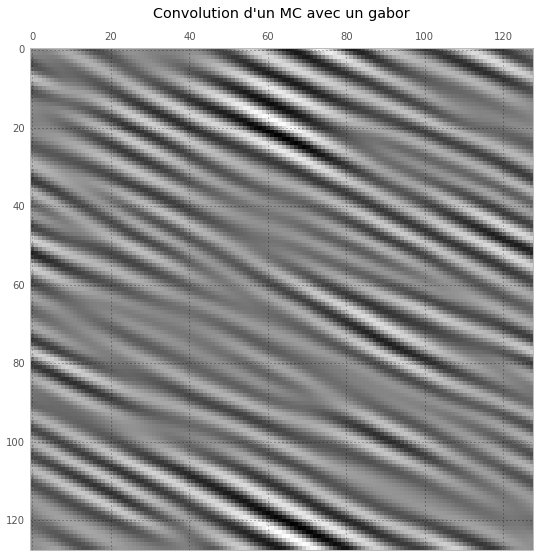

In [8]:
#from scipy.signal import fftconvolve as convolve
# convolution circulaire
def convolve(image_in, image_V1):
    env_in = np.fft.fft2(image_in)
    env_V1 = np.fft.fft2(image_V1)
    return np.fft.fftshift(np.fft.ifft2((env_in*env_V1)).real)

R = convolve(texture(env_in), impulse(env_V1))
print R.shape
fig, ax = plt.subplots(figsize=(14, 9))
ax.matshow(R, cmap=plt.cm.gray)
plt.title(u"Convolution d'un MC avec un gabor")
print (R**2).sum() / mc.N_X**4 # à normaliser

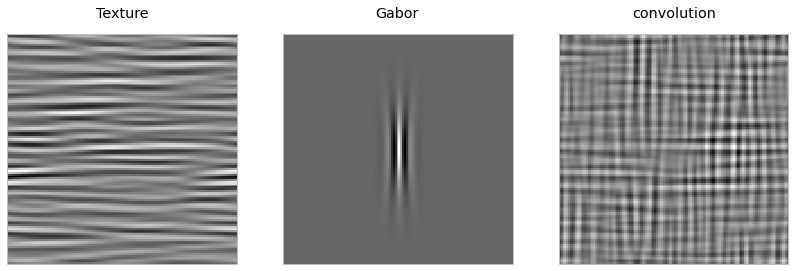

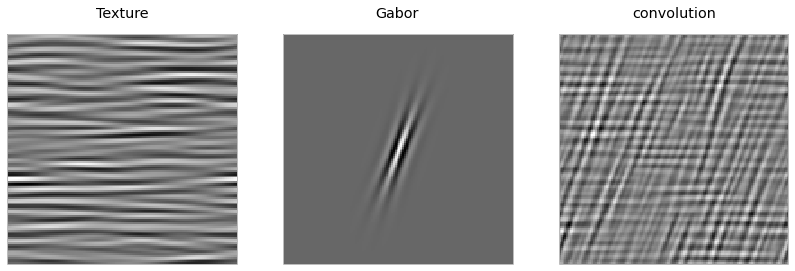

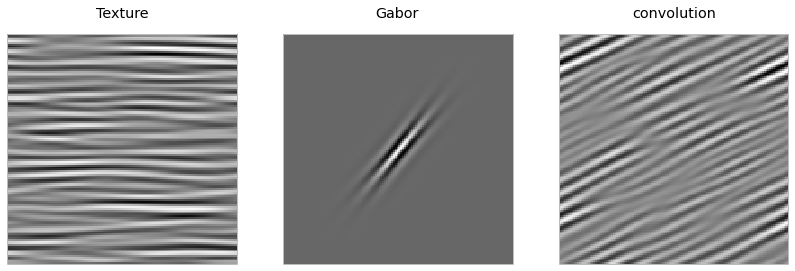

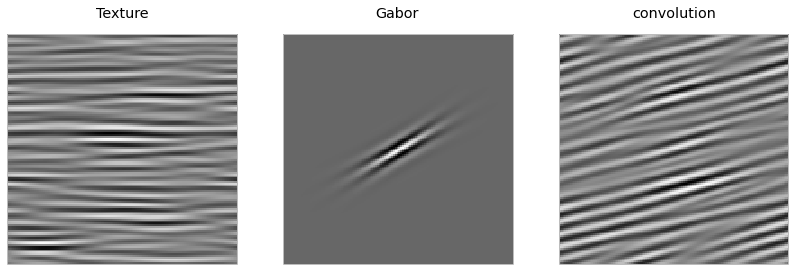

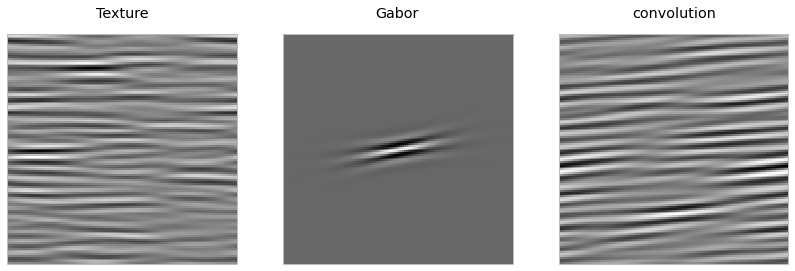

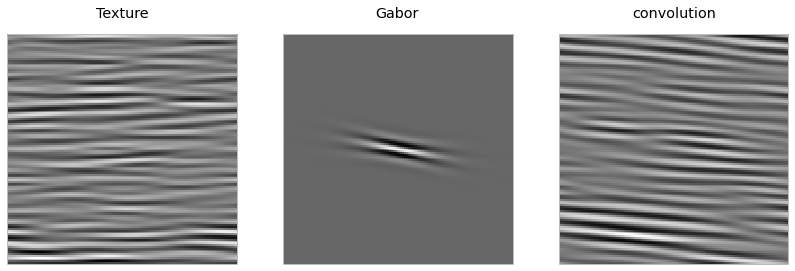

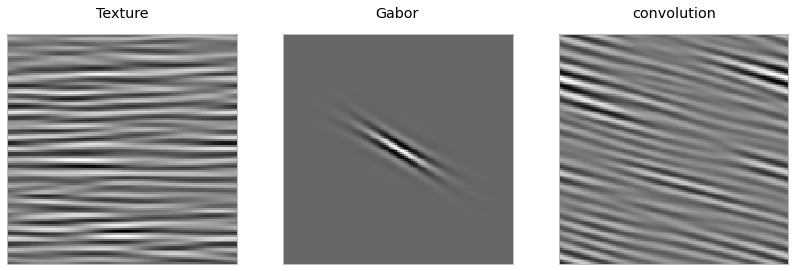

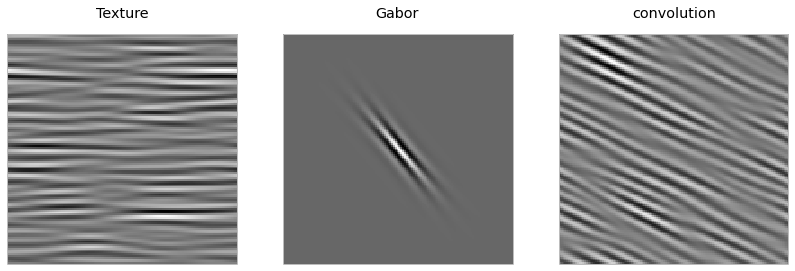

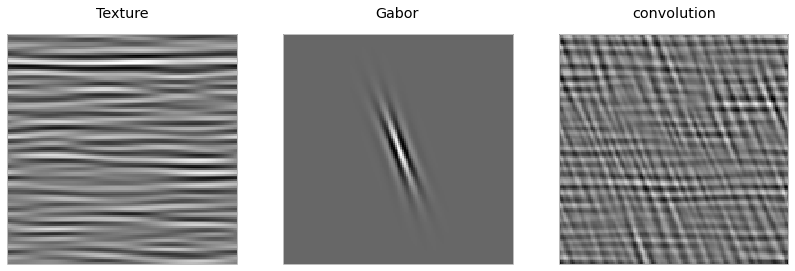

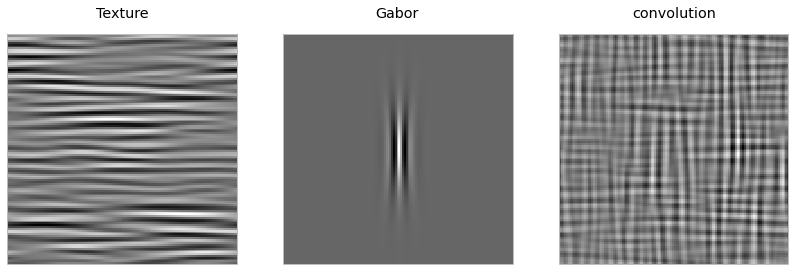

In [9]:
# images des convolutions avec différents angles
N_theta=360
theta0 = np.pi/2
theta_0 = np.linspace(0., np.pi, 10)

for i, theta0_ in enumerate(theta_0) :
    env_in = envelope_radial(fx, fy, sf_0=sf_0, B_sf=B_sf) * envelope_orientation(fx, fy, theta_0=theta0, B_theta=B_theta)
    env_V1 = envelope_radial(fx, fy, sf_0=sf_0, B_sf=B_sf) * envelope_orientation(fx, fy, theta_0=theta0_, B_theta=B_theta)
    R = convolve(texture(env_in), impulse(env_V1))
    fig, ax = plt.subplots(1, 3, figsize=(14, 9))
    for i, (f, label) in enumerate(zip([texture(env_in), impulse(env_V1), R], [u'Texture', u'Gabor', u'convolution'])):
        ax[i].matshow(f, cmap=plt.cm.gray)
        ax[i].set_title(label)
        ax[i].set_xticks([])
        ax[i].set_yticks([])

# Figure

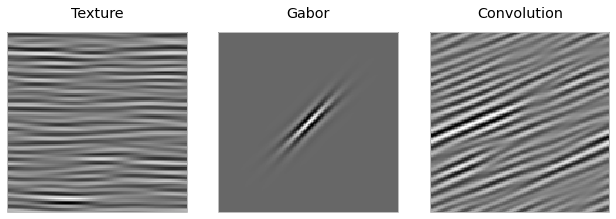

In [10]:
N_theta=360
theta0 = np.pi/2
theta_0 = np.pi/4

env_in = envelope_radial(fx, fy, sf_0=sf_0, B_sf=B_sf) * envelope_orientation(fx, fy, theta_0=theta0, B_theta=B_theta)
env_V1 = envelope_radial(fx, fy, sf_0=sf_0, B_sf=B_sf) * envelope_orientation(fx, fy, theta_0=theta_0, B_theta=B_theta)
R = convolve(texture(env_in), impulse(env_V1))

fig, ax = plt.subplots(1, 3, figsize=(fig_width, fig_width*6/18))
for i, (f, label) in enumerate(zip([texture(env_in), impulse(env_V1), R], [u'Texture', u'Gabor', u'Convolution'])):
    ax[i].matshow(f, cmap=plt.cm.gray)
    ax[i].set_title(label)
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    
plt.tight_layout()
fig.savefig('figures/texture_gabor_convolution(week4).pdf')

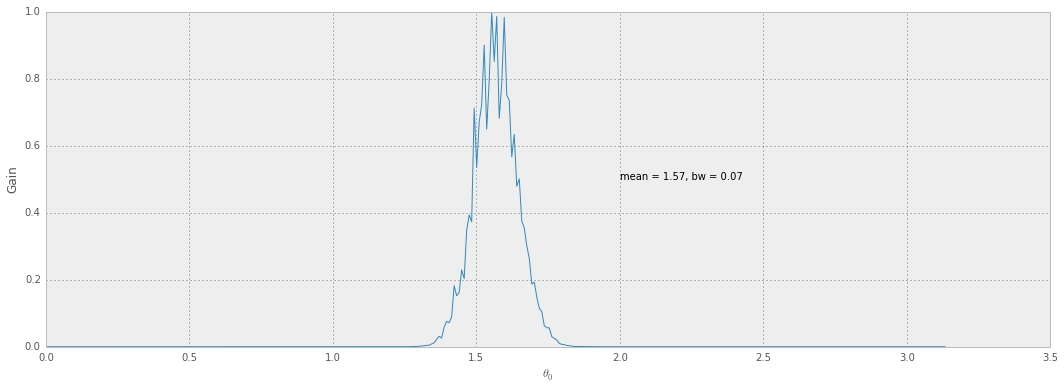

In [11]:
# évolution du gain / bandwidth avec différents angles
N_theta = 360
sf_0 = 0.15
B_sf = 0.05
theta0 = np.pi/2
theta_0 = np.linspace(0., np.pi, N_theta, endpoint=False)
B_theta = 0.15

gain = np.zeros((N_theta))

for i, theta0_ in enumerate(theta_0) :
    env_in = envelope_radial(fx, fy, sf_0=sf_0, B_sf=B_sf) * envelope_orientation(fx, fy, theta_0=theta0, B_theta=B_theta)
    env_V1 = envelope_radial(fx, fy, sf_0=sf_0, B_sf=B_sf) * envelope_orientation(fx, fy, theta_0=theta0_, B_theta=B_theta)
    R = convolve(texture(env_in), impulse(env_V1))
    gain[i] = (R**2).mean() / (mc.N_X*mc.N_Y)**2

mean = np.sum(gain*theta_0)/np.sum(gain)
bandwidth = np.sqrt(np.sum(gain*(theta_0-mean)**2)/np.sum(gain))
gain_max0 = gain.max()

fig, ax = plt.subplots(figsize=(18, 6))
_ = ax.plot(theta_0, gain / gain_max0 )
_ = ax.text(2., .5, 'mean = %.2f, bw = %.2f' % (mean,bandwidth))
_ = ax.set_xlabel(r'$\theta_{0}$')
_ = ax.set_ylabel(r'Gain')

## selectivite en fonction des paramètres du filtre de V1 (sf_0, B_sf, theta_0, B_theta)

### selectivite en fonction de sf_0

[ 1.572224    1.56942755  1.57033707  1.57174283  1.57255281] [ 0.08717323  0.07579885  0.07472725  0.07718378  0.07513938]


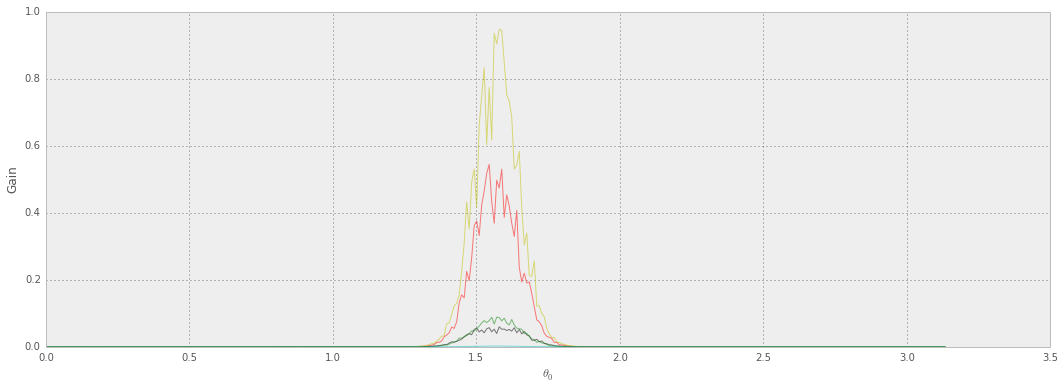

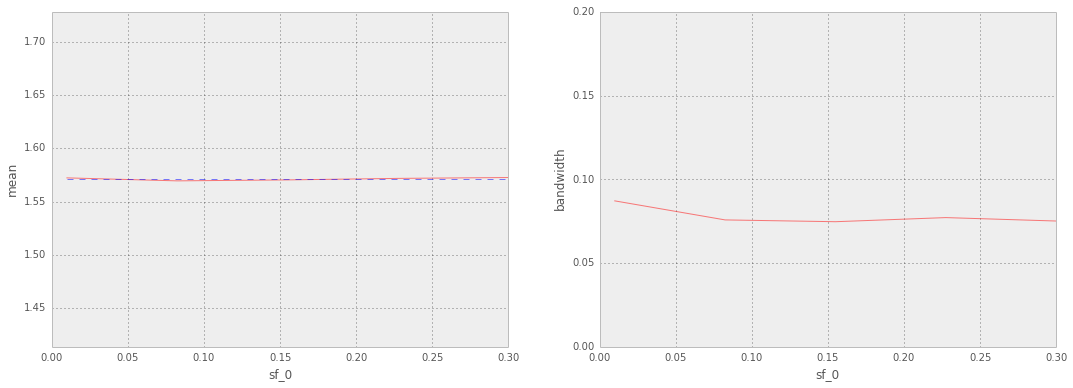

In [12]:
B_sf = 0.05
theta0 = np.pi/2
theta_0 = np.linspace(0., np.pi, N_theta, endpoint=False)
B_theta = 0.15


# évolution du gain en fonction de sf_0
N_test = 5
sf0 = 0.15
sf_0 = np.linspace(0.01, .3, N_test)

mean = np.zeros((N_test))
bandwidth = np.zeros((N_test))


fig, ax = plt.subplots(1, 1, figsize=(18, 6))
colors = ['k', 'r', 'y', 'g', 'c', 'b', 'ro', 'yo', 'go', 'co',  'bo']
for i_test, (sf_0_, color) in enumerate(zip(sf_0, colors[:N_test])):
    gain = np.zeros((N_theta))
    for i, theta0_ in enumerate(theta_0) :
        env_in = envelope_radial(fx, fy, sf_0=sf0, B_sf=B_sf) * envelope_orientation(fx, fy, theta_0=theta0, B_theta=B_theta)
        env_V1 = envelope_radial(fx, fy, sf_0=sf_0_, B_sf=B_sf) * envelope_orientation(fx, fy, theta_0=theta0_, B_theta=B_theta)
        R = convolve(texture(env_in), impulse(env_V1))
        gain[i] = ((R**2).mean() / (mc.N_X*mc.N_Y)**2) / gain_max0
    ax.plot(theta_0, gain , color, alpha=0.5)
    mean[i_test] = np.sum(gain*theta_0)/np.sum(gain)
    bandwidth[i_test] = np.sqrt(np.sum(gain*(theta_0-mean[i_test])**2)/np.sum(gain))
ax.set_xlabel(r'$\theta_{0}$')
ax.set_ylabel(r'Gain')

print mean, bandwidth

fig, ax = plt.subplots(1, 2, figsize=(18, 6))
ax[0].plot(sf_0, mean, 'r', alpha=0.5)
ax[0].plot(sf_0, theta0*np.ones(N_test), 'b--', alpha=0.5)
ax[0].set_ylim([.9*theta0, 1.1*theta0])
ax[1].plot(sf_0, bandwidth, 'r', alpha=0.5)
ax[1].set_ylim([0, .2])

#ax[0].axis('tight')
ax[0].set_xlabel(r'sf_0')
ax[0].set_ylabel(r'mean')
#ax[1].axis('tight')
ax[1].set_xlabel(r'sf_0')
_ = ax[1].set_ylabel(r'bandwidth')

### selectivite en fonction de B_sf

[ 1.5715285   1.57177095  1.56949447  1.5698324   1.56988947] [ 0.07328953  0.07574617  0.0754913   0.07768964  0.0754156 ]


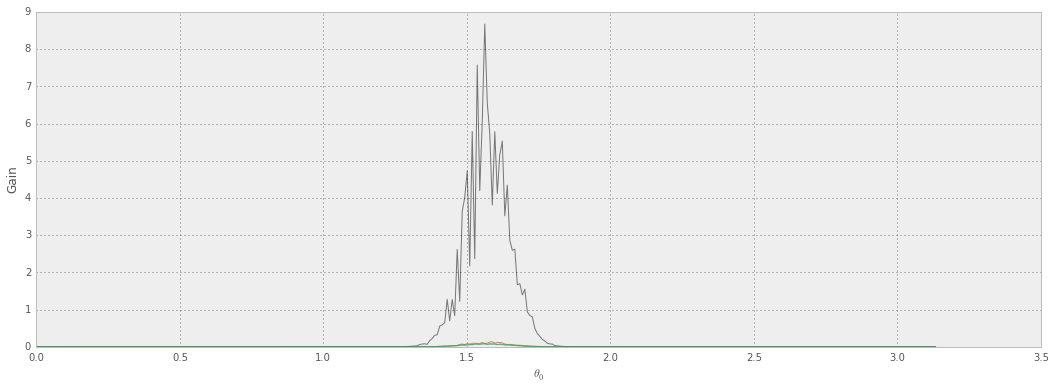

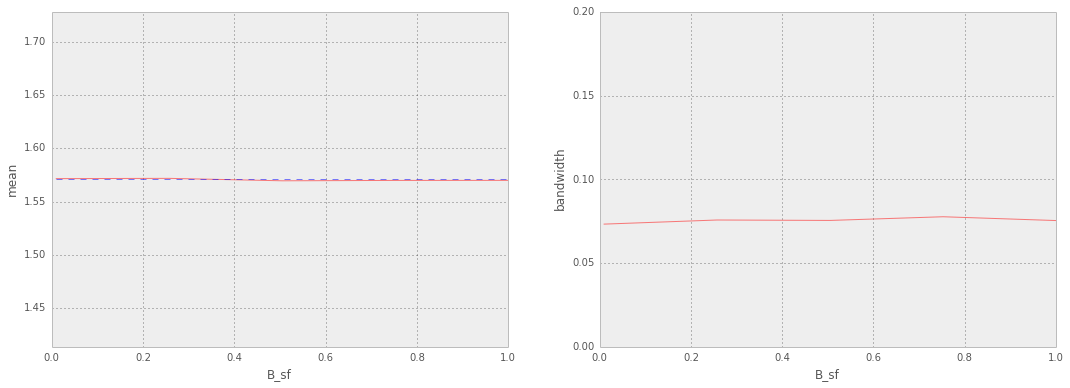

In [13]:
sf_0 = 0.15
theta0 = np.pi/2
theta_0 = np.linspace(0., np.pi, N_theta, endpoint=False)
B_theta = 0.15

# évolution du gain en fonction de B_sf
N_test = 5
Bsf = 0.05
B_sf = np.linspace(0.01, 1., N_test)

mean = np.zeros((N_test))
bandwidth = np.zeros((N_test))

fig, ax = plt.subplots(figsize=(18, 6))
for i_test, (B_sf_, color) in enumerate(zip(B_sf, colors[:N_test])):
    gain = np.zeros((N_theta))
    for i, theta0_ in enumerate(theta_0) :
        env_in = envelope_radial(fx, fy, sf_0=sf_0, B_sf=Bsf) * envelope_orientation(fx, fy, theta_0=theta0, B_theta=B_theta)
        env_V1 = envelope_radial(fx, fy, sf_0=sf_0, B_sf=B_sf_) * envelope_orientation(fx, fy, theta_0=theta0_, B_theta=B_theta)
        R = convolve(texture(env_in), impulse(env_V1))
        gain[i] = ((R**2).mean() / (mc.N_X*mc.N_Y)**2)/ gain_max0
    ax.plot(theta_0, gain, color, alpha=0.5)
    mean[i_test] = np.sum(gain*theta_0)/np.sum(gain)
    bandwidth[i_test] = np.sqrt(np.sum(gain*(theta_0-mean[i_test])**2)/np.sum(gain))
ax.set_xlabel(r'$\theta_{0}$')
ax.set_ylabel(r'Gain')


print mean, bandwidth


fig, ax = plt.subplots(1, 2, figsize=(18, 6))
ax[0].plot(B_sf, mean, 'r', alpha=0.5)
ax[0].plot(B_sf, theta0*np.ones(N_test), 'b--', alpha=0.5)
ax[0].set_ylim([.9*theta0, 1.1*theta0])
ax[1].plot(B_sf, bandwidth, 'r', alpha=0.5)
ax[1].set_ylim([0, .2])

#ax[0].axis('tight')
ax[0].set_xlabel(r'B_sf')
ax[0].set_ylabel(r'mean')
#ax[1].axis('tight')
ax[1].set_xlabel(r'B_sf')
_ = ax[1].set_ylabel(r'bandwidth')

### selectivite en fonction de B_theta

[ 1.56875403  1.57042957  1.57195141  1.57349354  1.56947689  1.56646674
  1.56732406  1.57067984  1.5726279   1.57197047] [ 0.06617958  0.12260714  0.19434988  0.28306913  0.40465995  0.52508696
  0.61788581  0.68543446  0.73341314  0.7687074 ]


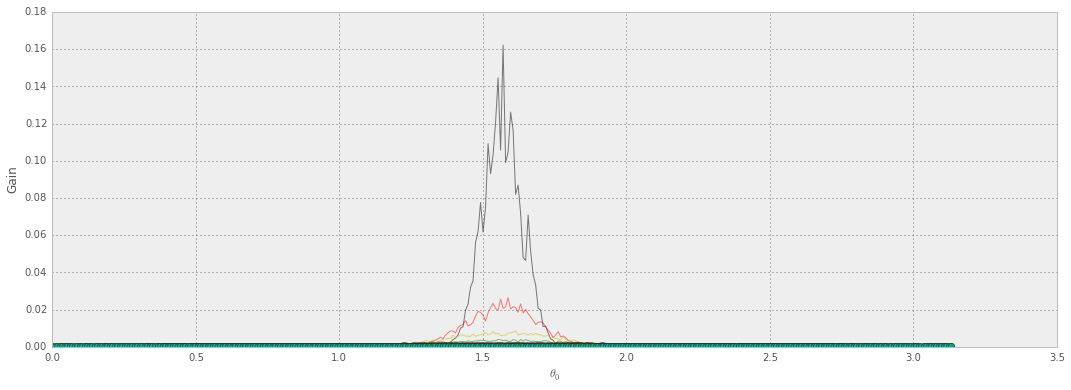

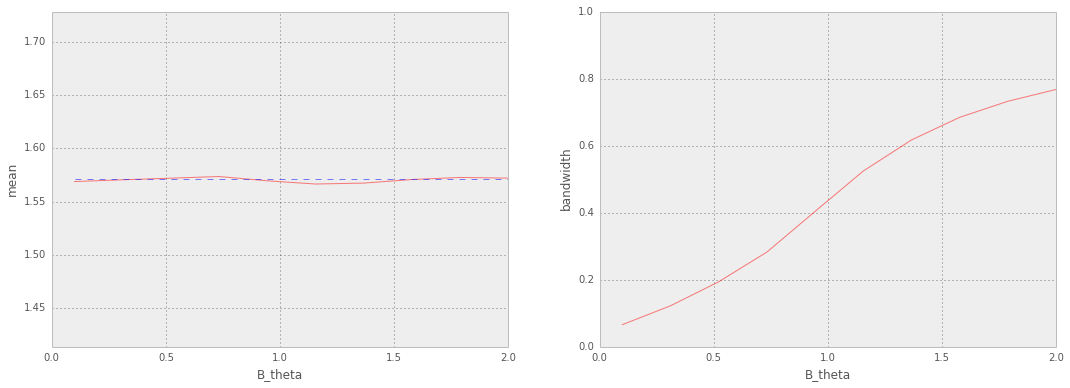

In [14]:
sf_0 = 0.15
B_sf = 0.05
theta0 = np.pi/2
theta_0 = np.linspace(0., np.pi, N_theta, endpoint=False)

# évolution du gain en fonction de B_theta
N_test = 10
Btheta = 0.15
B_theta = np.linspace(.1, 2., N_test)

mean = np.zeros((N_test))
bandwidth = np.zeros((N_test))

fig, ax = plt.subplots(figsize=(18, 6))
for i_test, (B_theta_, color) in enumerate(zip(B_theta, colors[:N_test])) :
    gain = np.zeros((N_theta))
    for i, theta0_ in enumerate(theta_0) :
        env_in = envelope_radial(fx, fy, sf_0=sf_0, B_sf=Bsf) * envelope_orientation(fx, fy, theta_0=theta0, B_theta=Btheta)
        env_V1 = envelope_radial(fx, fy, sf_0=sf_0, B_sf=B_sf_) * envelope_orientation(fx, fy, theta_0=theta0_, B_theta=B_theta_)
        R = convolve(texture(env_in), impulse(env_V1))
        gain[i] = ((R**2).mean() / (mc.N_X*mc.N_Y)**2)/gain_max0
    ax.plot(theta_0, gain, color, alpha=0.5)
    mean[i_test] = np.sum(gain*theta_0)/np.sum(gain)
    bandwidth[i_test] = np.sqrt(np.sum(gain*(theta_0-mean[i_test])**2)/np.sum(gain))
ax.set_xlabel(r'$\theta_{0}$')
ax.set_ylabel(r'Gain')

print mean, bandwidth

fig, ax = plt.subplots(1, 2, figsize=(18, 6))
ax[0].plot(B_theta, mean, 'r', alpha=0.5)
ax[0].plot(B_theta, theta0*np.ones(N_test), 'b--', alpha=0.5)
ax[0].set_ylim([.9*theta0, 1.1*theta0])
ax[1].plot(B_theta, bandwidth, 'r', alpha=0.5)
ax[1].set_ylim([0, 1.])

#ax[0].axis('tight')
ax[0].set_xlabel(r'B_theta')
ax[0].set_ylabel(r'mean')
#ax[1].axis('tight')
ax[1].set_xlabel(r'B_theta')
_ = ax[1].set_ylabel(r'bandwidth')

On observe que le changement des paramètre sf_0, B_sf, theta_0 ne modifie pas la moyenne et la bandwidth de la convolution

B_theta ne modifie pas la moyenne mais modifie la bandwidth (augmente puis semble arriver à saturation quand = 3.)

## Selectivite en fonction des paramètres de la texture (sf_0, B_sf, theta_0, B_theta)

### selectivite en fonction de sf_0

[ 1.57033552  1.57237246  1.5709161   1.57133805  1.56955788] [ 0.07639756  0.07522209  0.07440618  0.07535127  0.07554677]


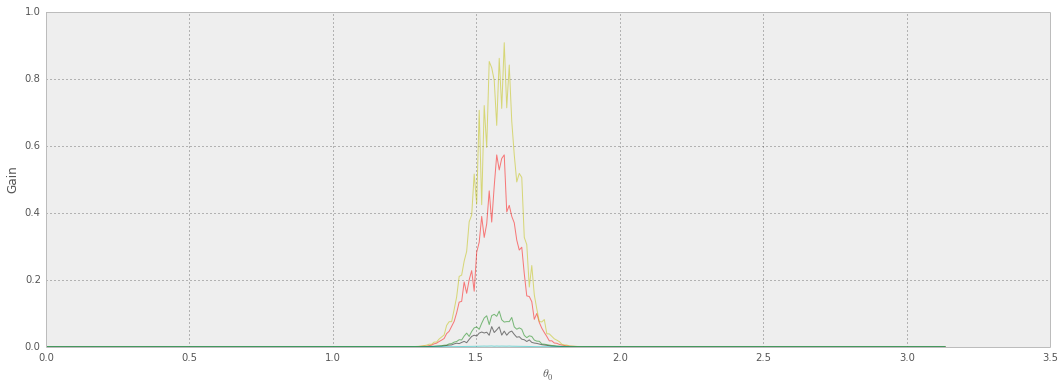

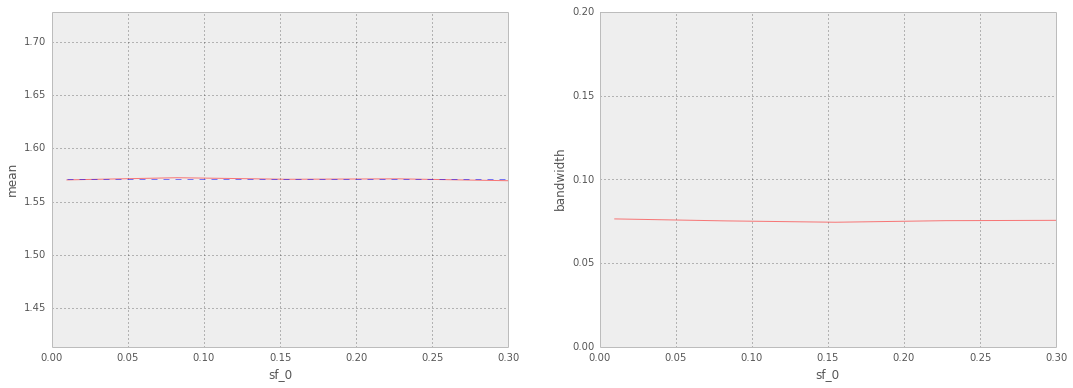

In [15]:
B_sf = 0.05
theta0 = np.pi/2
theta_0 = np.linspace(0., np.pi, N_theta, endpoint=False)
B_theta = 0.15


# évolution du gain en fonction de sf_0
N_test = 5
sf0 = 0.15
sf_0 = np.linspace(0.01, .3, N_test)

mean = np.zeros((N_test))
bandwidth = np.zeros((N_test))


fig, ax = plt.subplots(1, 1, figsize=(18, 6))
colors = ['k', 'r', 'y', 'g', 'c', 'b', 'ro', 'yo', 'go', 'co',  'bo']
for i_test, (sf_0_, color) in enumerate(zip(sf_0, colors[:N_test])):
    gain = np.zeros((N_theta))
    for i, theta0_ in enumerate(theta_0) :
        env_in = envelope_radial(fx, fy, sf_0=sf_0_, B_sf=B_sf) * envelope_orientation(fx, fy, theta_0=theta0, B_theta=B_theta)
        env_V1 = envelope_radial(fx, fy, sf_0=sf0, B_sf=B_sf) * envelope_orientation(fx, fy, theta_0=theta0_, B_theta=B_theta)
        R = convolve(texture(env_in), impulse(env_V1))
        gain[i] = ((R**2).mean() / (mc.N_X*mc.N_Y)**2) / gain_max0
    ax.plot(theta_0, gain , color, alpha=0.5)
    mean[i_test] = np.sum(gain*theta_0)/np.sum(gain)
    bandwidth[i_test] = np.sqrt(np.sum(gain*(theta_0-mean[i_test])**2)/np.sum(gain))
ax.set_xlabel(r'$\theta_{0}$')
ax.set_ylabel(r'Gain')

print mean, bandwidth

fig, ax = plt.subplots(1, 2, figsize=(18, 6))
ax[0].plot(sf_0, mean, 'r', alpha=0.5)
ax[0].plot(sf_0, theta0*np.ones(N_test), 'b--', alpha=0.5)
ax[0].set_ylim([.9*theta0, 1.1*theta0])
ax[1].plot(sf_0, bandwidth, 'r', alpha=0.5)
ax[1].set_ylim([0, .2])

#ax[0].axis('tight')
ax[0].set_xlabel(r'sf_0')
ax[0].set_ylabel(r'mean')
#ax[1].axis('tight')
ax[1].set_xlabel(r'sf_0')
_ = ax[1].set_ylabel(r'bandwidth')

### selectivite en fonction de B_sf

[ 1.56856432  1.57193146  1.56884488  1.57112907  1.5703577 ] [ 0.07462171  0.07558502  0.07447181  0.07376597  0.07590689]


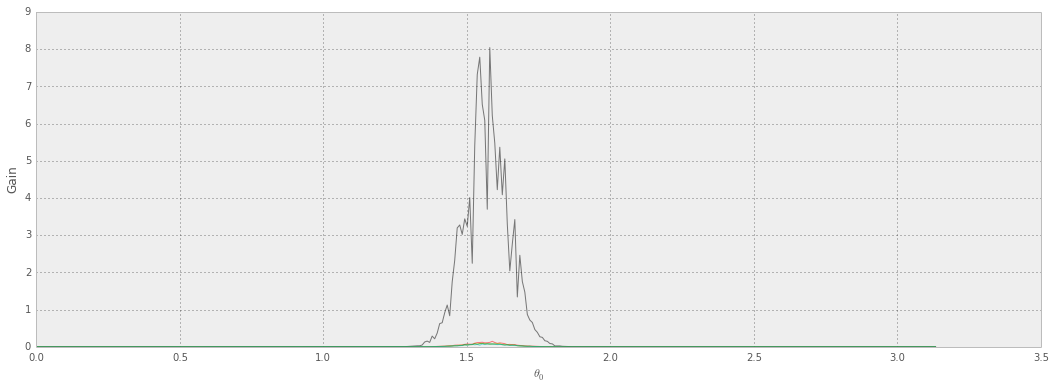

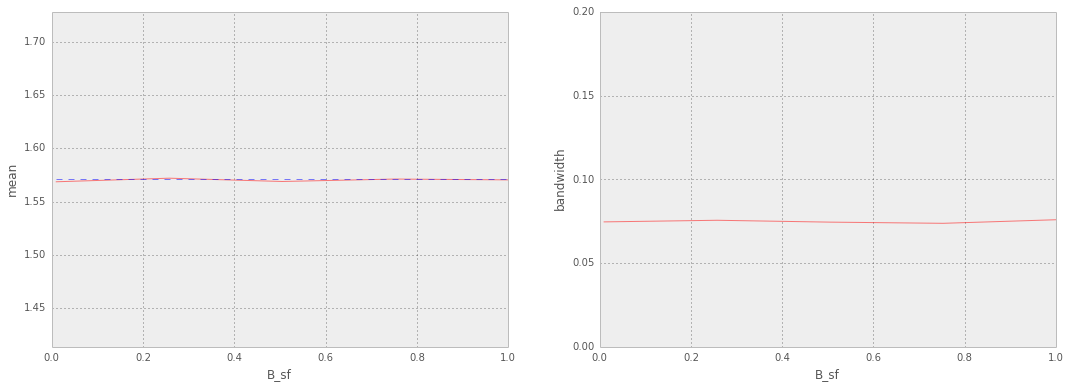

In [16]:
sf_0 = 0.15
theta0 = np.pi/2
theta_0 = np.linspace(0., np.pi, N_theta, endpoint=False)
B_theta = 0.15

# évolution du gain en fonction de B_sf
N_test = 5
Bsf = 0.05
B_sf = np.linspace(0.01, 1., N_test)

mean = np.zeros((N_test))
bandwidth = np.zeros((N_test))

fig, ax = plt.subplots(figsize=(18, 6))
for i_test, (B_sf_, color) in enumerate(zip(B_sf, colors[:N_test])):
    gain = np.zeros((N_theta))
    for i, theta0_ in enumerate(theta_0) :
        env_in = envelope_radial(fx, fy, sf_0=sf_0, B_sf=B_sf_) * envelope_orientation(fx, fy, theta_0=theta0, B_theta=B_theta)
        env_V1 = envelope_radial(fx, fy, sf_0=sf_0, B_sf=Bsf) * envelope_orientation(fx, fy, theta_0=theta0_, B_theta=B_theta)
        R = convolve(texture(env_in), impulse(env_V1))
        gain[i] = ((R**2).mean() / (mc.N_X*mc.N_Y)**2)/ gain_max0
    ax.plot(theta_0, gain, color, alpha=0.5)
    mean[i_test] = np.sum(gain*theta_0)/np.sum(gain)
    bandwidth[i_test] = np.sqrt(np.sum(gain*(theta_0-mean[i_test])**2)/np.sum(gain))
ax.set_xlabel(r'$\theta_{0}$')
ax.set_ylabel(r'Gain')


print mean, bandwidth


fig, ax = plt.subplots(1, 2, figsize=(18, 6))
ax[0].plot(B_sf, mean, 'r', alpha=0.5)
ax[0].plot(B_sf, theta0*np.ones(N_test), 'b--', alpha=0.5)
ax[0].set_ylim([.9*theta0, 1.1*theta0])
ax[1].plot(B_sf, bandwidth, 'r', alpha=0.5)
ax[1].set_ylim([0, .2])

#ax[0].axis('tight')
ax[0].set_xlabel(r'B_sf')
ax[0].set_ylabel(r'mean')
#ax[1].axis('tight')
ax[1].set_xlabel(r'B_sf')
_ = ax[1].set_ylabel(r'bandwidth')

# Figure
### selectivite en fonction de B_theta

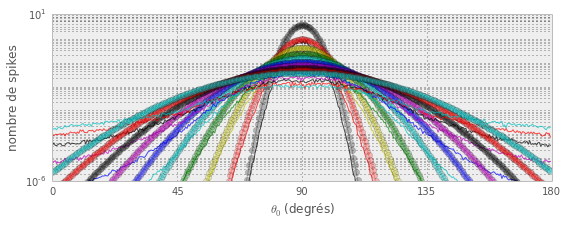

In [17]:
sf_0 = 0.15
B_sf = 0.05
theta0 = np.pi/2
theta_0 = np.linspace(0., np.pi, N_theta, endpoint=False)

# évolution du gain en fonction de B_theta
N_test = 10
Btheta = 0.15
B_theta = np.linspace(.1, 1., N_test)

N_gabor, xmax = 100, np.pi
dx = xmax / N_gabor
theta_out = np.linspace(0., np.pi, N_gabor)

mean = np.zeros((N_test))
bandwidth = np.zeros((N_test))
gain_out = np.zeros(B_theta.shape)
sigma_p = np.zeros(B_theta.shape)
gain_p = np.zeros(B_theta.shape)
mean_p = np.zeros(B_theta.shape)

colors = ['k', 'r', 'y', 'g', 'c', 'b', 'm', 'k', 'r', 'c', 'g', 'c', 'b', 'm']

fig, ax = plt.subplots(figsize=(fig_width, fig_width*6/18.))
for i_test, (B_theta_, color) in enumerate(zip(B_theta, colors[:N_test])) :
    gain = np.zeros((N_theta))
    p = np.zeros((N_theta))
    for i, theta0_ in enumerate(theta_0) :
        env_in = envelope_radial(fx, fy, sf_0=sf_0, B_sf=Bsf) * envelope_orientation(fx, fy, theta_0=theta0, B_theta=B_theta_)
        env_V1 = envelope_radial(fx, fy, sf_0=sf_0, B_sf=B_sf_) * envelope_orientation(fx, fy, theta_0=theta0_, B_theta=Btheta)
        p[i] = (dx/(2*np.pi*B_theta_*Btheta))*np.exp(-2*((theta0_-theta0)**2)/(B_theta_**2+Btheta**2))
        R = convolve(texture(env_in), impulse(env_V1))
        gain[i] = ((R**2).mean() / (mc.N_X*mc.N_Y)**2)/ gain_max0 / .18
    gain_out[i_test] = gain.max()
    mean_p[i_test] = np.sum((p**2)*theta_0)/np.sum(p**2)
    gain_p[i_test] = p.max()
    ax.semilogy(theta_0*180/np.pi, gain, color, alpha=0.7)
    ax.semilogy(theta_0*180/np.pi,(p**2)/dx, color, marker='o', alpha=0.25)
    mean[i_test] = np.sum(gain*theta_0)/np.sum(gain)
    bandwidth[i_test] = np.sqrt(np.sum(gain*(theta_0-mean[i_test])**2)/np.sum(gain))
ax.set_xlim([0, 180])
ax.set_ylim([1e-6, 10.])
ax.set_xticks(np.linspace(0, 180, 5))
ax.set_yticks(np.linspace(1e-6, 10, 5))
#plt.tight_layout()
ax.set_xlabel(r'$\theta_{0}$ ' u'(degrés)')
ax.set_ylabel(r'nombre de spikes')
#ax.set_title(u'Courbe de sélectivité en fonction du paramêtre de la texture ' r'$B_{\theta}$')
fig.savefig('figures/selectivite_Btheta(week4).pdf')

In [18]:
print gain_out,gain_p, gain_out/gain_p
gain_p /= gain_out.max()
gain_out /= gain_out.max()
print gain_out,gain_p, gain_out/gain_p


[ 0.81912921  0.2717424   0.15869923  0.08300208  0.05510532  0.04008408
  0.02650276  0.01915059  0.01457867  0.01089413] [ 0.33333333  0.16666667  0.11111111  0.08333333  0.06666667  0.05555556
  0.04761905  0.04166667  0.03703704  0.03333333] [ 2.45738762  1.63045442  1.42829305  0.996025    0.82657983  0.72151337
  0.55655793  0.45961406  0.3936241   0.32682392]
[ 1.          0.33174547  0.19374139  0.10132966  0.06727305  0.04893499
  0.0323548   0.0233792   0.01779777  0.01329965] [ 0.40693621  0.2034681   0.1356454   0.10173405  0.08138724  0.0678227
  0.05813374  0.05086703  0.04521513  0.04069362] [ 2.45738762  1.63045442  1.42829305  0.996025    0.82657983  0.72151337
  0.55655793  0.45961406  0.3936241   0.32682392]


In [19]:
R.shape

(128, 128)

[ 1.          0.33174547  0.19374139  0.10132966  0.06727305  0.04893499
  0.0323548   0.0233792   0.01779777  0.01329965]


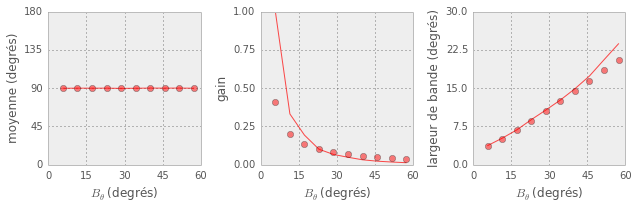

In [20]:
fig, ax = plt.subplots(1, 3, figsize=(fig_width, fig_width*6/18.))
ax[0].plot(B_theta*180/np.pi, mean*180/np.pi, 'r', alpha=0.7)
#ax[0].plot(B_theta*180/np.pi, theta0*np.ones(N_test)*180/np.pi, 'k--', alpha=0.7)
ax[0].plot(B_theta*180/np.pi, mean_p*180/np.pi, 'ro', alpha=0.5)
ax[0].set_xlim([0., 60.])
ax[0].set_ylim([0., 180.])
ax[0].set_xticks(np.linspace(0, 60, 5))
ax[0].set_yticks(np.linspace(0., 180., 5))
ax[1].plot(B_theta*180/np.pi, gain_out, 'r', alpha=0.7)
ax[1].plot(B_theta*180/np.pi, gain_p, 'ro', alpha=0.5)
ax[1].set_xlim([0., 60.])
ax[1].set_ylim([0., gain_out.max()])
ax[1].set_xticks(np.linspace(0, 60, 5))
ax[1].set_yticks(np.linspace(0, 1, 5))
ax[2].plot(B_theta*180/np.pi, bandwidth*180/np.pi, 'r', alpha=0.7)
ax[2].plot(B_theta*180/np.pi, np.sqrt(.25/2*(B_theta**2+Btheta**2))*180/np.pi, 'ro', alpha=0.5)
#ax[2].set_xlim([0., 60.])
#ax[2].set_ylim([0, 30])
ax[2].set_xticks(np.linspace(0, 60, 5))
ax[2].set_yticks(np.linspace(0, 30, 5))

#ax[0].axis('tight')
ax[0].set_xlabel(r'$B_{\theta}$ ' u'(degrés)')
ax[0].set_ylabel(u'moyenne (degrés)')

ax[1].set_xlabel(r'$B_{\theta}$ ' u'(degrés)')
ax[1].set_ylabel(r'gain')
#ax[1].axis('tight')
ax[2].set_xlabel(r'$B_{\theta}$ ' u'(degrés)')
_ = ax[2].set_ylabel(u'largeur de bande (degrés)')
plt.tight_layout()
fig.savefig('figures/mean_gain_bandwidth_Btheta(week4).pdf')
print gain_out

On observe que le changement des paramètre sf_0, B_sf, theta_0 ne modifie pas la moyenne et la bandwidth de la convolution

B_theta ne modifie pas la moyenne mais modifie la bandwidth (augmente puis semble arriver à saturation quand = 3.)

## Prédiction théorique

**Réponse spikante**

I = les stimili

G = recepteur

F est la fonction de fourier

$$ I = F^{-1}(\varepsilon \cdot e^{i \phi})$$
$$ G = F^{-1}(\varepsilon^{,})$$

Réponse linéaire neuronale :
$$ I \circ G = F^{-1}(F(I) \cdot F(G)) = F^{-1}(\varepsilon^{,} \cdot \varepsilon \cdot e^{i \phi}) $$

d'après le théorème de Parseval :
$$ (f)^{2} = (F(f))^{2} $$

la réponse spikante est donc : $$ (I \circ G)^{2} = (\varepsilon^{,} \cdot \varepsilon \cdot e^{i \phi})^{2} = \varepsilon^{2} \cdot \varepsilon^{,2}$$

Multiplication de deux fonctions gaussiennes $\varepsilon$ et $\gamma$ donne une gaussienne :

$$ \varepsilon(x) = \frac {1} {\sigma_{1} \sqrt{2\pi}} \cdot e^{\frac {-(x-m_{1})^{2}} {2\sigma_{1}^{2}}}
~~et~~
\gamma (x) = \frac {1} {\sigma_2 \sqrt{2\pi}} \cdot e^{\frac {-(x-m_2)^{2}} {2\sigma_{2}^{2}}} $$


$$ (\varepsilon \cdot \gamma) (m) = \frac {G} {\sigma \sqrt{2\pi}} \cdot e^{\frac{-(m-m)^{2}} {2\sigma^{2}}} $$

$$ \sigma^{-2} = \sigma_{1}^{-2} + \sigma_{2}^-{2} $$
$$ m \sigma^{-2} = m_{1} \sigma_{1}^{-2} + m_{2} \sigma_{2}^{-2} $$

en particulier, la valeur à la moyenne $m$ donne:

$$ (\varepsilon \cdot \gamma) (m) = \varepsilon(m) \cdot \gamma(m) = \frac {1} {2\pi \sigma_1 \sigma_2} \cdot e^{- \frac{1}{2} \frac{(m_2-m_1)^{2}}{\sigma_{1}^{2} + \sigma_{2}^{2}}}$$


donc $~\frac{G}{\sigma \sqrt{2\pi}} = \frac{1}{2\pi \sigma_1 \sigma_2} \cdot e^{- \frac{1}{2} \frac{(m_2-m_1)^{2}}{\sigma_{1}^{2} + \sigma_{2}^{2}}}$ car $~e^{\frac{-(m-m)^{2}}{2\sigma^{2}}} = e^{0} = 1 $

Le gain $~\frac{G}{\sigma \sqrt{2\pi}}$ est donc modulé par la différence entre les deux moyennes et leurs $\sigma$



0.4995 0.4995 1.68060869714e-12 1.68173219025e-08


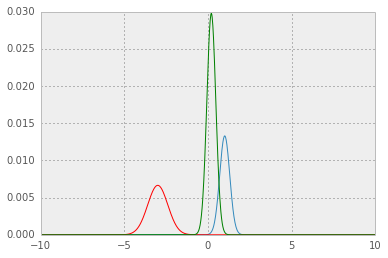

In [21]:
def gain_theorique(m1, m2, sigma1, sigma2):
    return 1/(2*np.pi*sigma1*sigma2)*np.exp(-.5*(m2-m1)**2/(sigma2**2+sigma1**2))

N, xmax = 1000, 10.
x = np.linspace(-xmax, xmax, N)
dx = xmax / N
m1, sigma1 = 1, .3
m2, sigma2 = -3, .6 
p1 = dx/(np.sqrt(2*np.pi)*sigma1)*np.exp(-.5*(x-m1)**2/sigma1**2)
#p1 /= p1.sum()
p2 = dx/(np.sqrt(2*np.pi)*sigma2)*np.exp(-.5*(x-m2)**2/sigma2**2)
plt.plot(x, p1)
plt.plot(x, p2, 'r')
plt.plot(x, p1*p2/(p1*p2).sum(), 'g')
print p1.sum(), p2.sum(), (p1*p2).max(), gain_theorique(m1, m2, sigma1, sigma2)

0.4995 0.4995 0.845297326761 0.845757094654


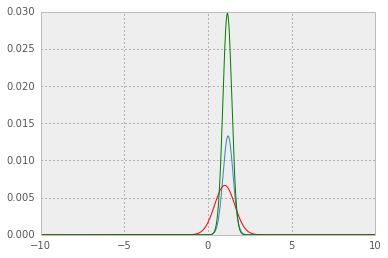

In [22]:
m1, sigma1 = 1.2, .3
m2, sigma2 = 1., .6
p1 = (dx/(np.sqrt(2*np.pi)*sigma1))*np.exp(-.5*(x-m1)**2/sigma1**2)
p2 = (dx/(np.sqrt(2*np.pi)*sigma2))*np.exp(-.5*(x-m2)**2/sigma2**2)
plt.plot(x, p1)
plt.plot(x, p2, 'r')
plt.plot(x, p1*p2/(p1*p2).sum(), 'g')
print p1.sum(), p2.sum(), (p1*p2/dx**2).max(), gain_theorique(m1, m2, sigma1, sigma2)

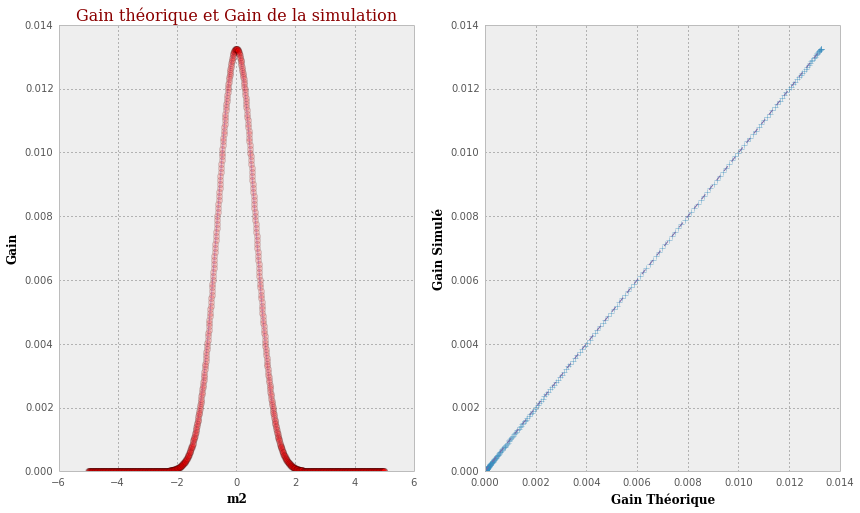

In [23]:
m1, sigma1 = 0, .2
m2, sigma2 = np.linspace (-5, 5, 1000), .6

def gain_sim(m1, m2, sigma1, sigma2, dx):
    p1 = (dx/(np.sqrt(2*np.pi)*sigma1))*np.exp(-.5*(x-m1)**2/sigma1**2)
    p2 = (dx/(np.sqrt(2*np.pi)*sigma2))*np.exp(-.5*(x-m2)**2/sigma2**2)
    return (p1*p2/dx).max()

G_sim = np.linspace (-5, 5, 1000)
for i, m2_ in enumerate(m2):
    G_sim[i] = gain_sim(m1, m2_, sigma1, sigma2, dx)

# ici G = G/(np.sqrt(2*np.pi)*sigma)
G = (dx/(2*np.pi*sigma1*sigma2))*np.exp(-.5*((m2-m1)**2)/(sigma1**2+sigma2**2))

fig, ax = plt.subplots(1, 2, figsize=(14, 8))
ax[0].plot(m2, G, 'b', m2, G_sim, 'ro', alpha=.2)

font = {'family' : 'serif',
        'color'  : 'darkred',
        'weight' : 'normal',
        'size'   : 16,
        }
font1 = {'family' : 'serif',
        'color'  : 'black',
        'weight' : 'bold',
        'size'   : 12,
        }

ax[0].set_title(u'Gain théorique et Gain de la simulation', fontdict=font)
ax[0].set_xlabel(u'm2', fontdict=font1)
ax[0].set_ylabel(u'Gain', fontdict=font1)
#print p1.sum(), p2.sum(), (p1*p2).max(), gain_theorique(m1, m2, sigma1, sigma2)
ax[1].plot(G , G_sim, '+', alpha=.4)
ax[1].plot(np.linspace(G.min(), G.max(), 100),np.linspace(G_sim.min(), G_sim.max(), 100), '--')
ax[1].set_xlabel(u'Gain Théorique', fontdict=font1)
ax[1].set_ylabel(u'Gain Simulé', fontdict=font1)


In [24]:
# maintenant on varie la bandwidth pour 3 valeurs de m2 = [m1-1, m1, m1+1]

## comparaison avec la vraie convolution

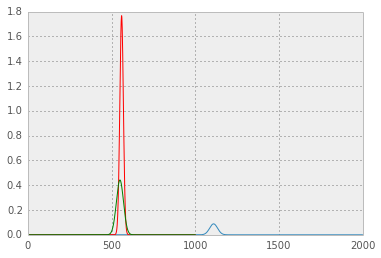

In [25]:
convo = (np.convolve(p1, p2)/dx)**2
plt.plot(convo)
plt.plot((p1/dx)**2, 'r')
plt.plot((p2/dx)**2, 'g')

on va maintenant appliquer aux textures

In [26]:
from IPython.display import FileLink
FileLink('Week 5.ipynb',url_prefix='')


/Users/lolo/Dropbox/ChloePasturel/Week 5.ipynb